# AutoML using H2O  
## MIT-Chile Workshop 
#### by Cristobal Donoso

[H2O](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html) is a level 3 AutoML system[1] that automates the exploration, selection, and validation of ML algorithms. 

>...is an open source, in-memory, distributed, fast, and scalable machine learning and predictive analytics platform that allows you to build machine learning models on big data and provides easy productionalization of those models in an enterprise environment.

The easiest way to install H2O is via [anaconda](https://www.anaconda.com/): 
```
conda install -c h2oai h2o
```
You can also explore other [installation alternatives](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/downloading.html)

<font size="1"> [1] Karmaker, Shubhra Kanti, et al. "Automl to date and beyond: Challenges and opportunities." ACM Computing Surveys (CSUR) 54.8 (2021): 1-36. </font>

When you load H2O, It will start an instance that runs in a specific *ip* and *port*. By default `ip=localhost` and `port=54321`

In [20]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

import pandas as pd
import matplotlib.pyplot as plt

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,13 mins 53 secs
H2O_cluster_timezone:,America/Santiago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.3
H2O_cluster_version_age:,1 month and 13 days
H2O_cluster_name:,H2O_from_python_cridonoso_2218ms
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.826 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### Preprocessing data

We'll use *daily accumulated precipitation* data [from the Chilean Ministry of Science](https://github.com/MinCiencia/Datos-CambioClimatico/tree/main/output/agua24_dmc)

In [2]:
base = 'https://raw.githubusercontent.com/MinCiencia/Datos-CambioClimatico/main/output/agua24_dmc'
url = base+'/{}/{}_agua24_dmc.csv'

As an example we will use data from 1951 to 2020

In [3]:
dates = pd.date_range(start='1951', end='2020', freq='A')

In [4]:
# %%time
# frames = []
# for date in dates:
#     try:
#         frame = pd.read_csv(url.format(date.year, date.year))[['time', 'RRR24_Valor']]
# #         print(frame.shape)
#         frame['RRR24_Valor'] = pd.to_numeric(frame['RRR24_Valor'])
#         frame = [date.date().strftime('%m/%d/%Y'), frame['RRR24_Valor'].mean(), frame['RRR24_Valor'].std()]
#         frames.append(frame)
#     except:
#         continue
# water_data = pd.DataFrame(frames, columns=['date', 'mean', 'std'])
# water_data.to_csv('water_data.csv', index=False)

In [21]:
water_data = pd.read_csv('water_data.csv')
water_data.head()

,date,mean,std
0,12/31/1955,2.000000,NaN
1,12/31/1956,NaN,NaN
2,12/31/1957,1.781818,2.669014
3,12/31/1958,7.123333,14.382597
4,12/31/1959,1.503005,5.500228


In [22]:
water_data['date'] = pd.to_datetime(water_data['date'])
water_data['mean'] = pd.to_numeric(water_data['mean'])
water_data['std']  = pd.to_numeric(water_data['std'])

water_data = water_data.set_index('date').sort_index()
water_data['mean'] = water_data['mean'].fillna(value=0)
water_data['std'] = water_data['std'].fillna(value=0)

In [23]:
water_data.head()

,mean,std
date,,
1955-12-31,2.000000,0.000000
1956-12-31,0.000000,0.000000
1957-12-31,1.781818,2.669014
1958-12-31,7.123333,14.382597
1959-12-31,1.503005,5.500228


Text(0.5, 0, 'Date')

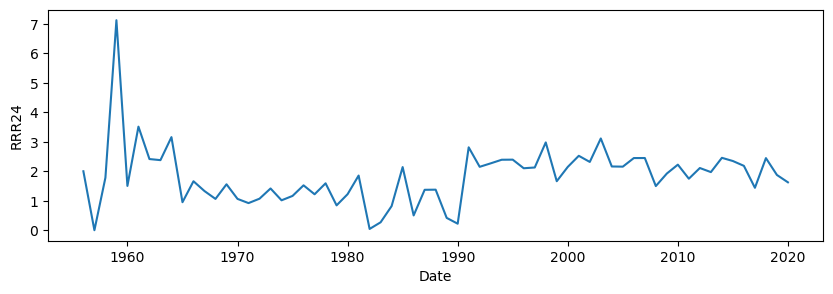

In [24]:
plt.figure(figsize=(10,3), dpi=100)
plt.plot(water_data.index, water_data['mean'])
plt.ylabel('RRR24')
plt.xlabel('Date')

Let's say that our task consist on predicting yearly-average of the accumulated precipitation in Chile

In [25]:
for lag in range(1, 5):
    water_data[f'value_{lag}_lag'] = water_data['mean'].shift(lag)

In [27]:
water_data.head()

,mean,std,value_1_lag,value_2_lag,value_3_lag,value_4_lag
date,,,,,,
1955-12-31,2.000000,0.000000,NaN,NaN,NaN,NaN
1956-12-31,0.000000,0.000000,2.000000,NaN,NaN,NaN
1957-12-31,1.781818,2.669014,0.000000,2.000000,NaN,NaN
1958-12-31,7.123333,14.382597,1.781818,0.000000,2.0,NaN
1959-12-31,1.503005,5.500228,7.123333,1.781818,0.0,2.0


Let's define our testing set as the last year in our dataset

In [28]:
testing_ds = water_data.iloc[-5:]
training_ds = water_data.iloc[:-5]

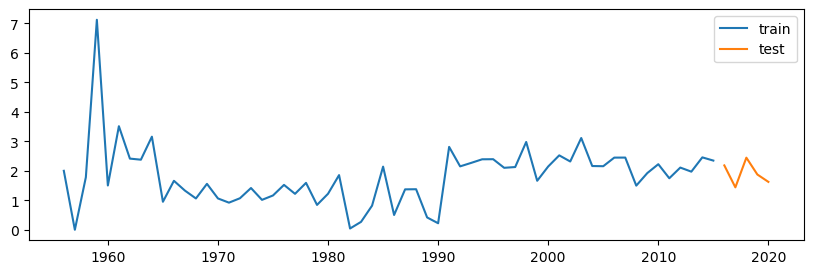

In [29]:
plt.figure(figsize=(10,3))
plt.plot(training_ds.index, training_ds['mean'], label='train')
plt.plot(testing_ds.index, testing_ds['mean'], label='test')
plt.legend()
plt.show()

We load the DataFrame using `H20Frame`

In [30]:
h2o_fram = h2o.H2OFrame(training_ds)
h2o_fram_test = h2o.H2OFrame(testing_ds)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


we need to tell h2o what is the label column (i.e., `mean`) and remove it from the training set

In [14]:
x, y = h2o_fram.columns, 'mean'
x.remove(y)
x.remove('std') # we do not want to predict std

Now we can start training!

In [15]:
h2o_automl = H2OAutoML(sort_metric='mse', max_runtime_secs=5*60, seed=666)
h2o_automl.train(x=x, y=y, training_frame=h2o_fram)

AutoML progress: |
23:45:05.211: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 60.0.

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_1_20230105_234504_model_26


Status of Neuron Layers: predicting mean, regression, gaussian distribution, Quadratic loss, 121 weights/biases, 4.8 KB, 600,000 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate               rate_rms                momentum    mean_weight           weight_rms           mean_bias              bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ----------------------  ----------------------  ----------  --------------------  -------------------  ---------------------  -----------------------
    1        4        Input             0.0
    2        20       RectifierDropout  30.0       0.0   0.0   0.0005454328355881443   0.00048180040903389454  0.0         -0.12344577669391583  0.42797207832336426  -0.005815192326058242  0.46612977981567383
    3        1        Linear                       0.0   0.0   0.00011760592806240311  4.9985494115389884e-05  0.0         0.12070727720856667   0.45949864387512207  0.16175017127633637    1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.40813625026798944
RMSE: 0.6388554220384997
MAE: 0.43181270741403094
RMSLE: 0.24981044651824885
Mean Residual Deviance: 0.40813625026798944

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 0.7753994904041185
RMSE: 0.8805677091536565
MAE: 0.5679808779807717
RMSLE: 0.3063660915497031
Mean Residual Deviance: 0.7753994904041185

Cross-Validation Metrics Summary: 
                        mean      sd        cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  --------  ------------  ------------  ------------  ------------  ------------
mae                     0.567981  0.202335  0.419502      0.661882      0.587951      0.842089      0.32848
mean_residual_deviance  0.7754    0.801596  0.25048       0.710636      0.505662      2.16647       0.24375
mse                     0.7754    0.801596  0.25048       0.710636      0.505662      2.16647       0.24375
r2                      0.278636  0.248333  0.586         -0.0344506    0.138578      0.24212       0.460934
residual_deviance       0.7754    0.801596  0.25048       0.710636      0.505662      2.16647       0.24375
rmse                    0.804035  0.401446  0.500479      0.842993      0.711099      1.47189       0.49371
rmsle                   0.292685  0.101217  0.178721      0.432206      0.278128      0.351422      0.222946

Scoring History: 
    timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_deviance    training_mae    training_r2
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  -------------------  --------------  -------------
    2023-01-05 23:48:09  0.000 sec                           0         0             0          nan              nan                  nan             nan
    2023-01-05 23:48:09  2 min 58.176 sec  200000 obs/sec    10        1             600        1.00132          1.00264              0.668134        0.0743372
    2023-01-05 23:48:10  2 min 59.289 sec  538116 obs/sec    10000     1000          600000     0.638855         0.408136             0.431813        0.623199

Variable Importances: 
variable     relative_importance    scaled_importance    percentage
-----------  ---------------------  -------------------  ------------
value_2_lag  1                      1                    0.384048
value_4_lag  0.592219               0.592219             0.22744
value_1_lag  0.531056               0.531056             0.203951
value_3_lag  0.480568               0.480568             0.184561

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

using `get_leaderboard` we can display trained models sorted by the evaluation metric we used (`sort_metric=mse`)

In [16]:
h2o_models = h2o.automl.get_leaderboard(h2o_automl, extra_columns='ALL')
h2o_models

model_id,mse,rmse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
DeepLearning_grid_1_AutoML_1_20230105_234504_model_26,0.775399,0.880568,0.567981,0.306366,0.775399,1118,0.011037,DeepLearning
DeepLearning_grid_1_AutoML_1_20230105_234504_model_25,0.806505,0.898056,0.544423,0.312218,0.806505,2986,0.008886,DeepLearning
DeepLearning_grid_1_AutoML_1_20230105_234504_model_17,0.835228,0.913908,0.589838,0.315101,0.835228,904,0.004971,DeepLearning
DeepLearning_grid_1_AutoML_1_20230105_234504_model_1,0.835359,0.91398,0.594935,0.313276,0.835359,1332,0.008047,DeepLearning
DeepLearning_grid_1_AutoML_1_20230105_234504_model_14,0.837274,0.915027,0.612997,0.314018,0.837274,1179,0.006044,DeepLearning
DeepLearning_grid_1_AutoML_1_20230105_234504_model_5,0.841561,0.917366,0.600127,0.325938,0.841561,2145,0.007155,DeepLearning
DeepLearning_grid_1_AutoML_1_20230105_234504_model_10,0.863248,0.929112,0.57353,0.321662,0.863248,2769,0.00789,DeepLearning
DeepLearning_grid_1_AutoML_1_20230105_234504_model_4,0.866812,0.931028,0.564719,0.314319,0.866812,3166,0.007704,DeepLearning
StackedEnsemble_BestOfFamily_4_AutoML_1_20230105_234504,0.870536,0.933025,0.579588,0.321865,0.870536,107,0.057592,StackedEnsemble
DeepLearning_grid_1_AutoML_1_20230105_234504_model_9,0.888305,0.942499,0.591481,0.325251,0.888305,708,0.007172,DeepLearning


[Look at the models that h2o uses during training](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science.html#algorithms)

In [17]:
y_pred = h2o_automl.predict(h2o_fram_test)

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


In [18]:
# plt.plot(y_pred['predict'].values)
results = pd.DataFrame(data = {'actual':h2o_fram_test['mean'].as_data_frame().to_numpy().ravel(), 
                               'predicted':y_pred.as_data_frame().to_numpy().ravel()})

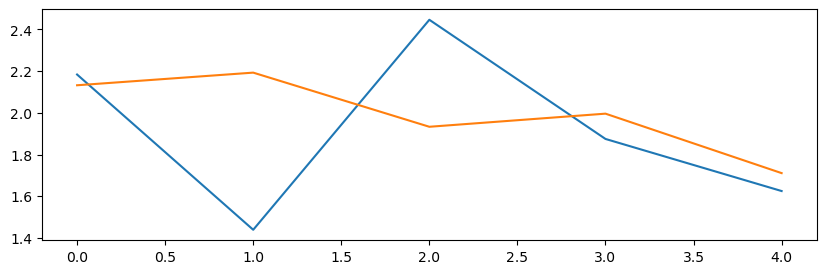

In [19]:
plt.figure(figsize=(10,3))
plt.plot(results['actual'], label='true')
plt.plot(results['predicted'], label='predicted')

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_BestOfFamily_5_AutoML_1_20230105_234504,0.339578,0.115313,0.226337,0.120819,0.115313,311,0.201381,StackedEnsemble
GBM_grid_1_AutoML_1_20230105_234504_model_117,0.339718,0.115408,0.294804,0.115599,0.115408,25,0.018162,GBM
DeepLearning_grid_3_AutoML_1_20230105_234504_model_5,0.344319,0.118555,0.292367,0.117674,0.118555,27,0.0374,DeepLearning
DeepLearning_grid_1_AutoML_1_20230105_234504_model_35,0.344384,0.118601,0.313295,0.11791,0.118601,6,0.011982,DeepLearning
XGBoost_grid_1_AutoML_1_20230105_234504_model_5,0.360908,0.130255,0.283428,0.121953,0.130255,36,0.015016,XGBoost
DeepLearning_grid_1_AutoML_1_20230105_234504_model_34,0.365454,0.133557,0.306967,0.126314,0.133557,9,0.012054,DeepLearning
GLM_1_AutoML_1_20230105_234504,0.366102,0.134031,0.309414,0.12557,0.134031,15,0.057329,GLM
DeepLearning_grid_2_AutoML_1_20230105_234504_model_19,0.367845,0.13531,0.305655,0.12782,0.13531,41,0.03216,DeepLearning
DeepLearning_grid_1_AutoML_1_20230105_234504_model_20,0.371606,0.138091,0.286908,0.127666,0.138091,800,0.014534,DeepLearning
DeepLearning_grid_1_AutoML_1_20230105_234504_model_15,0.376182,0.141513,0.299391,0.129933,0.141513,1069,0.014452,DeepLearning


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

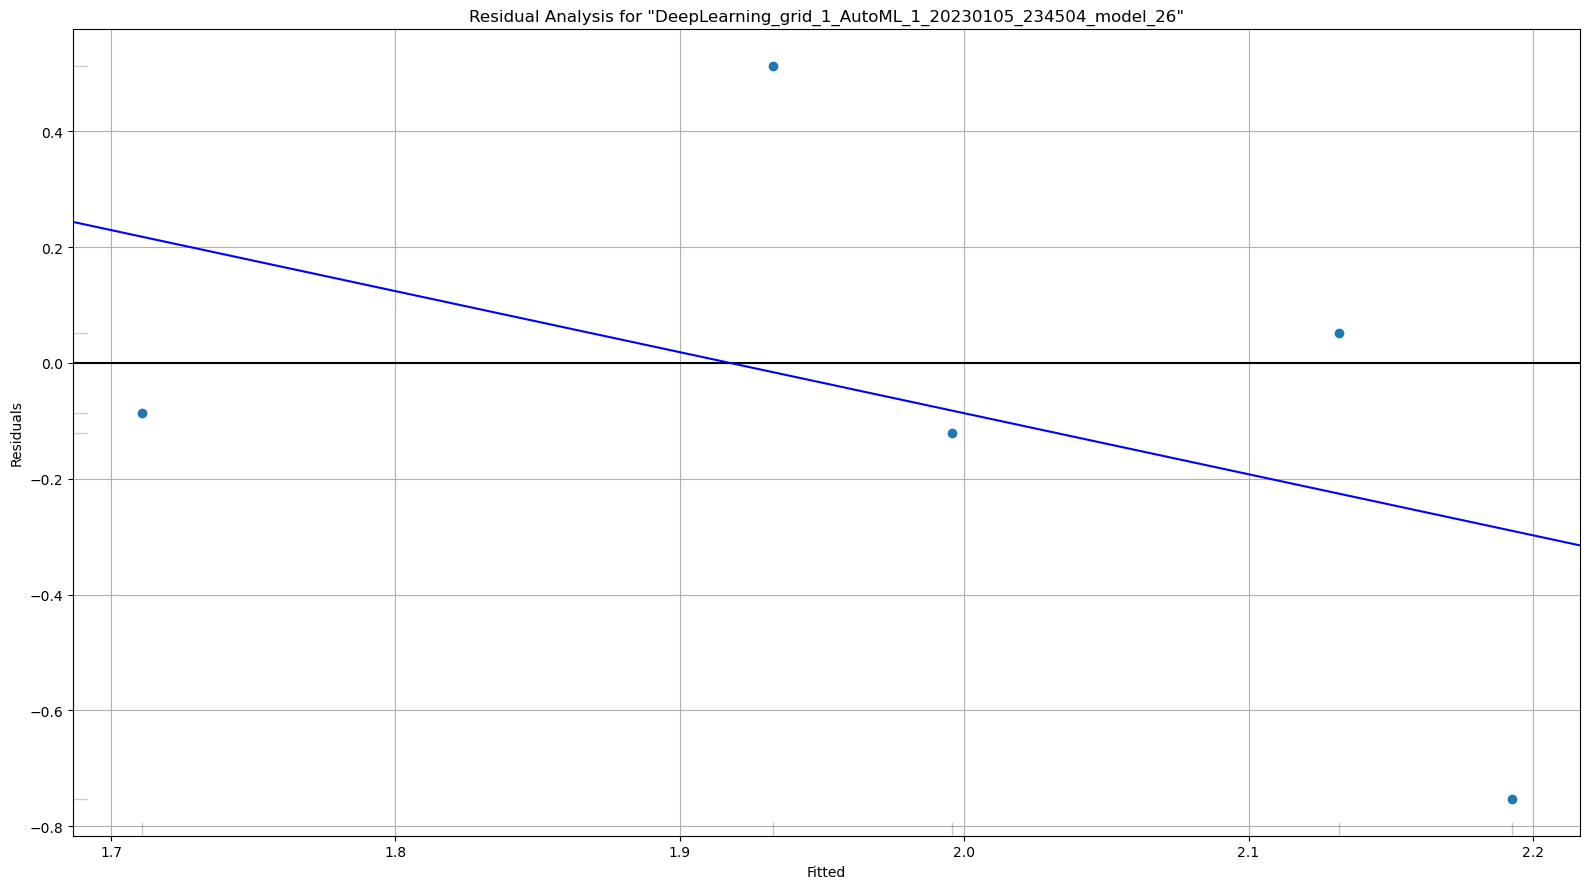

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

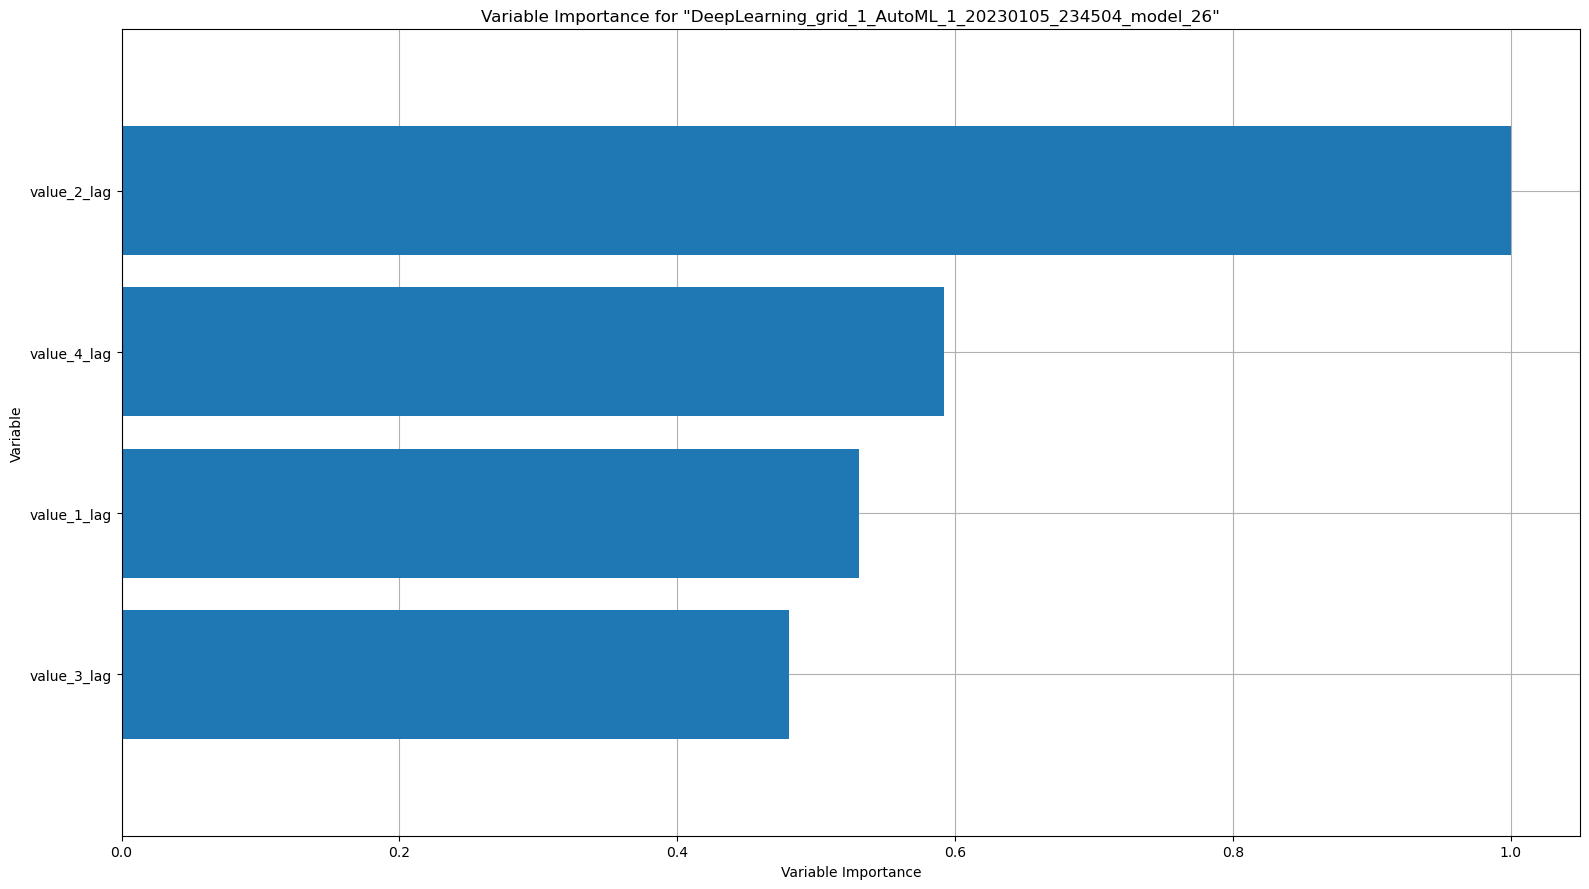

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

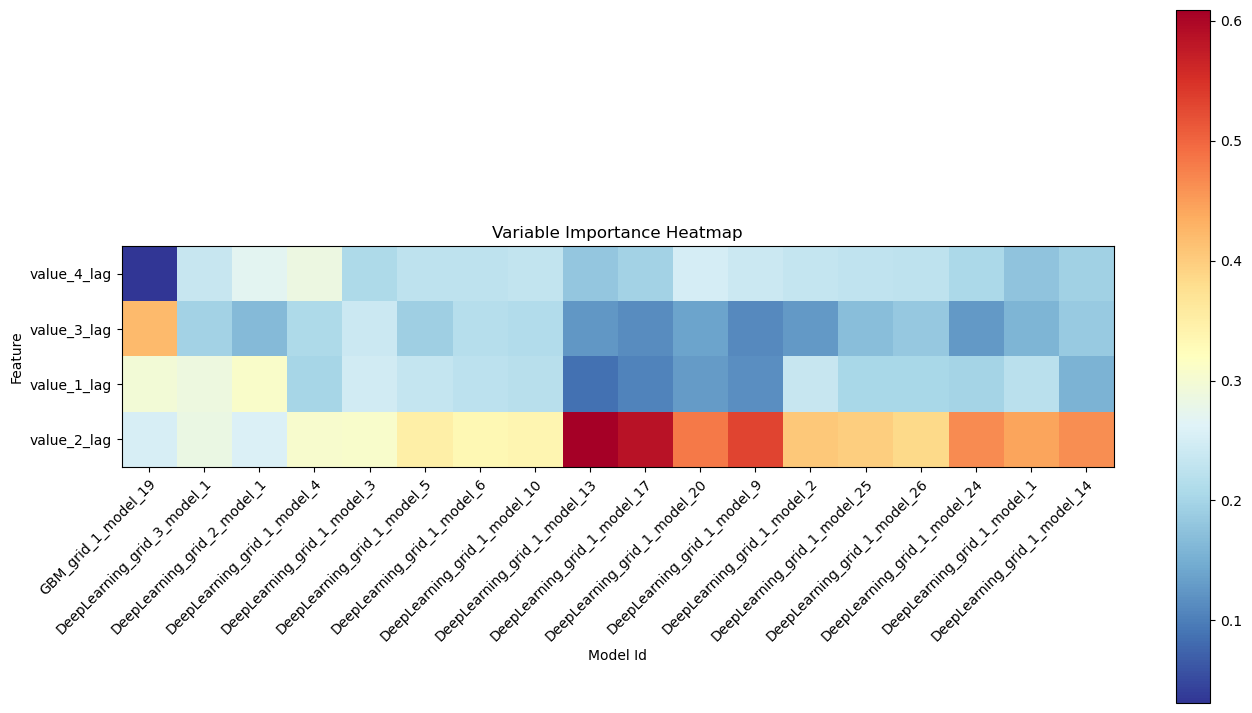

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

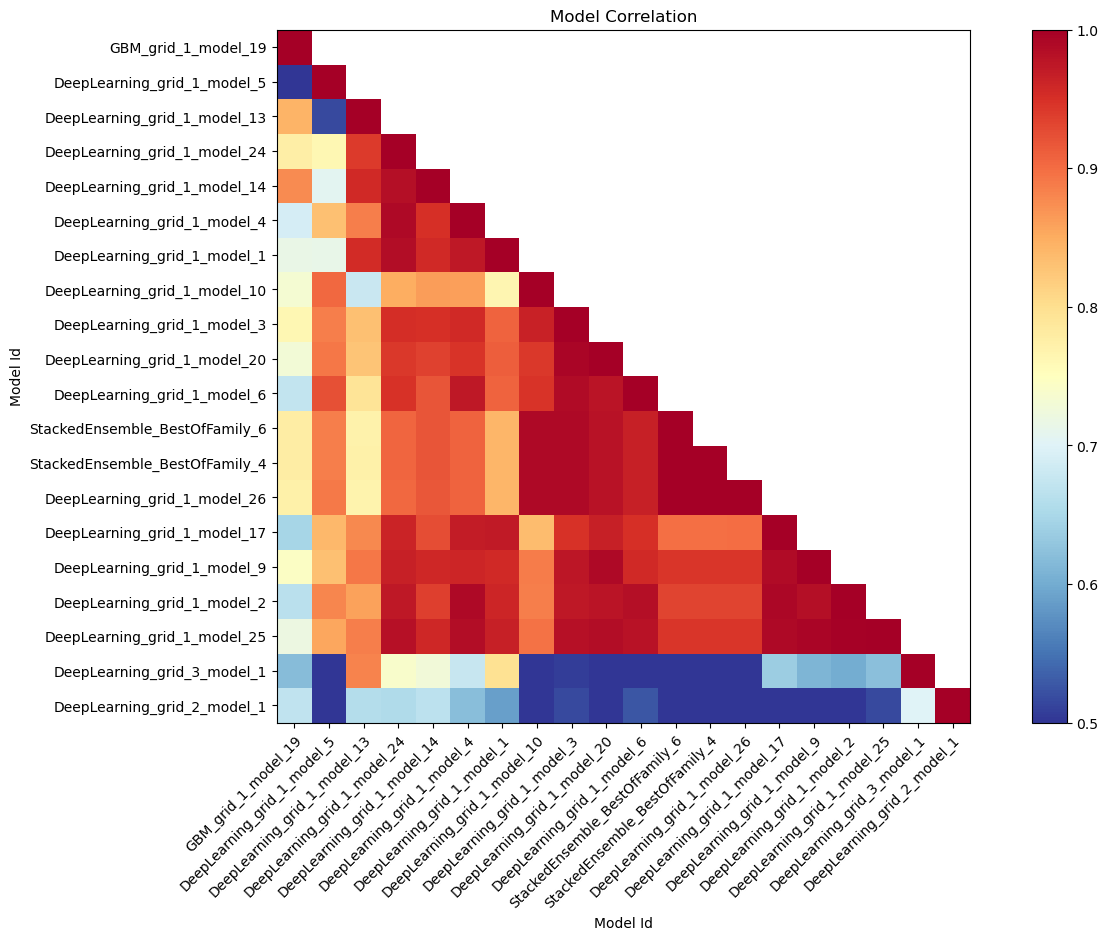

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

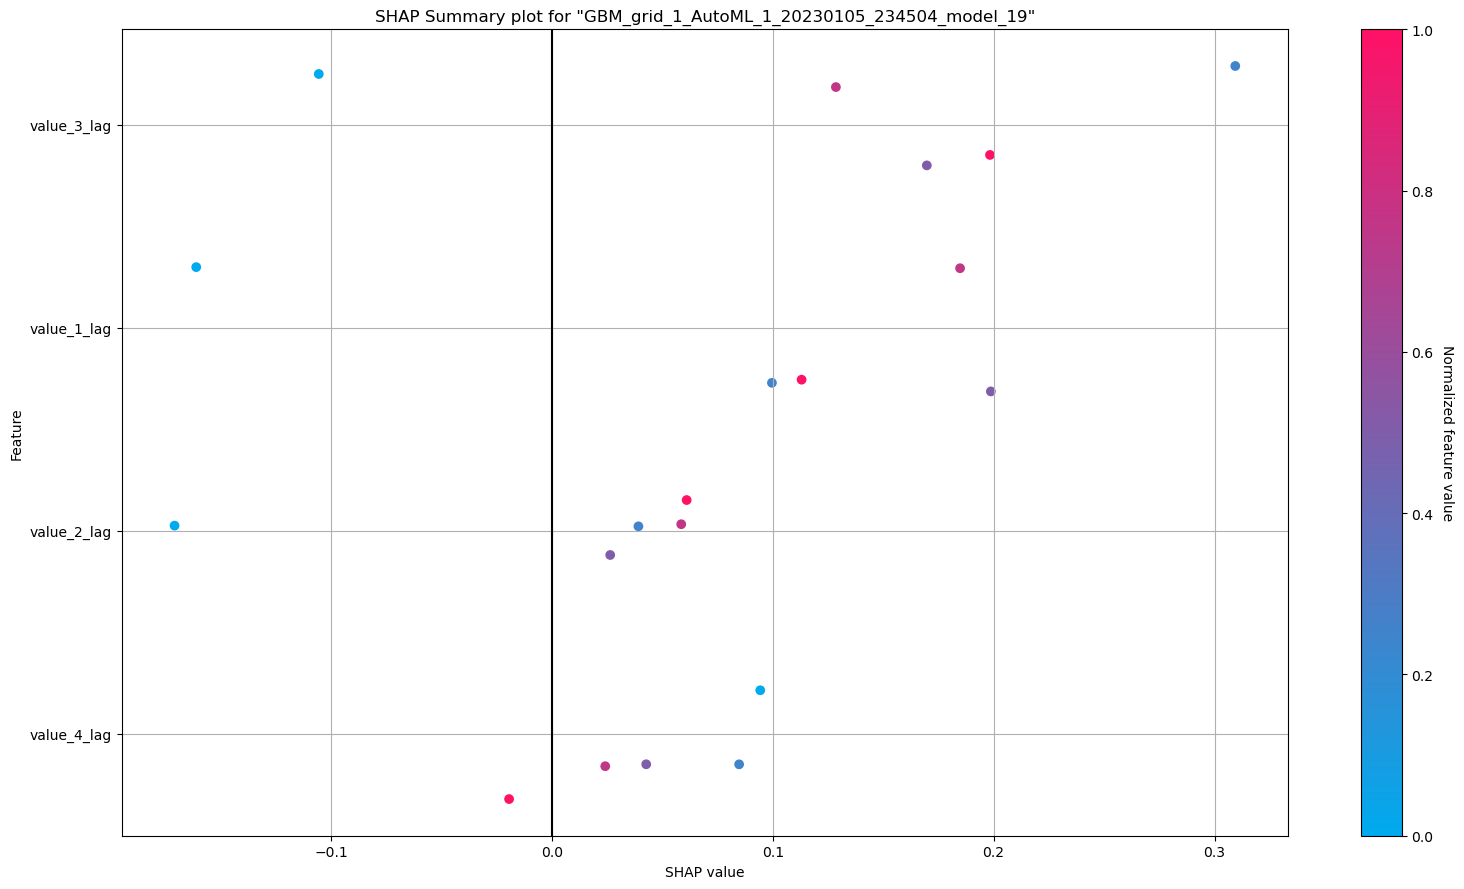

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

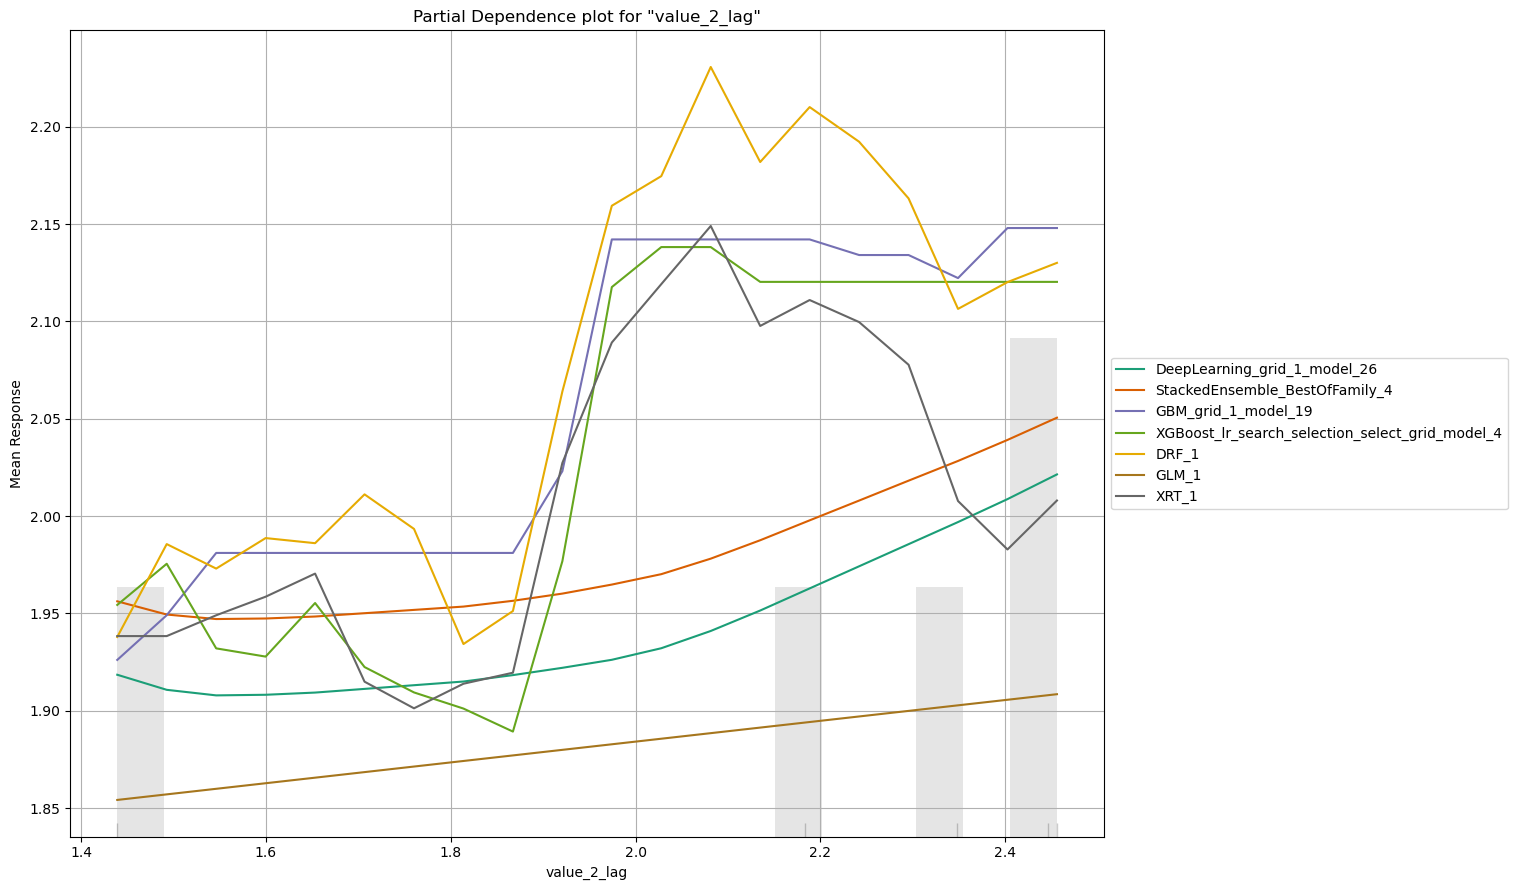

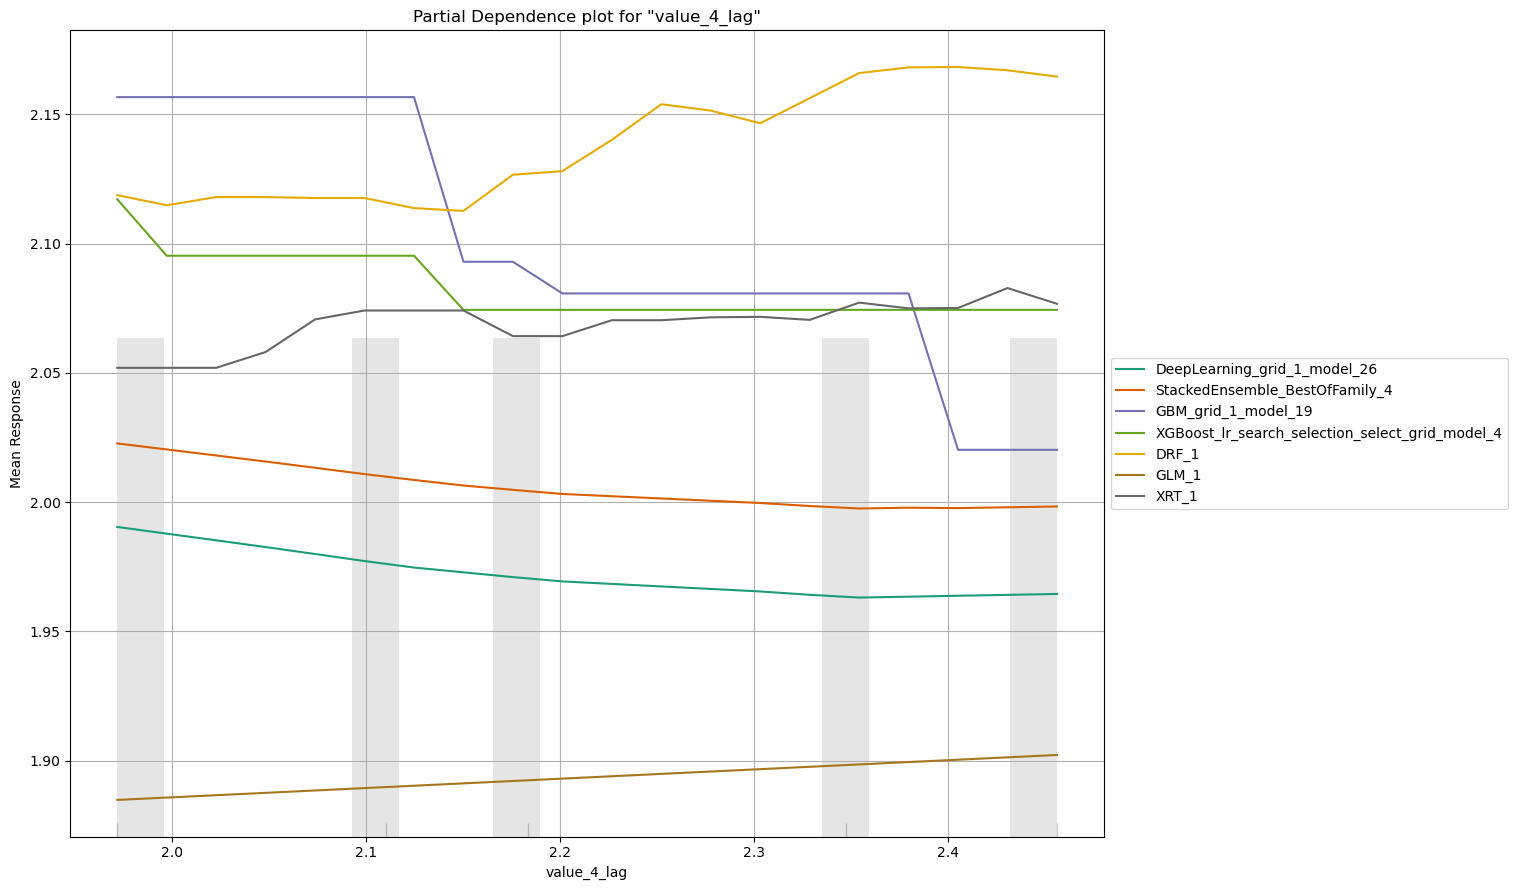

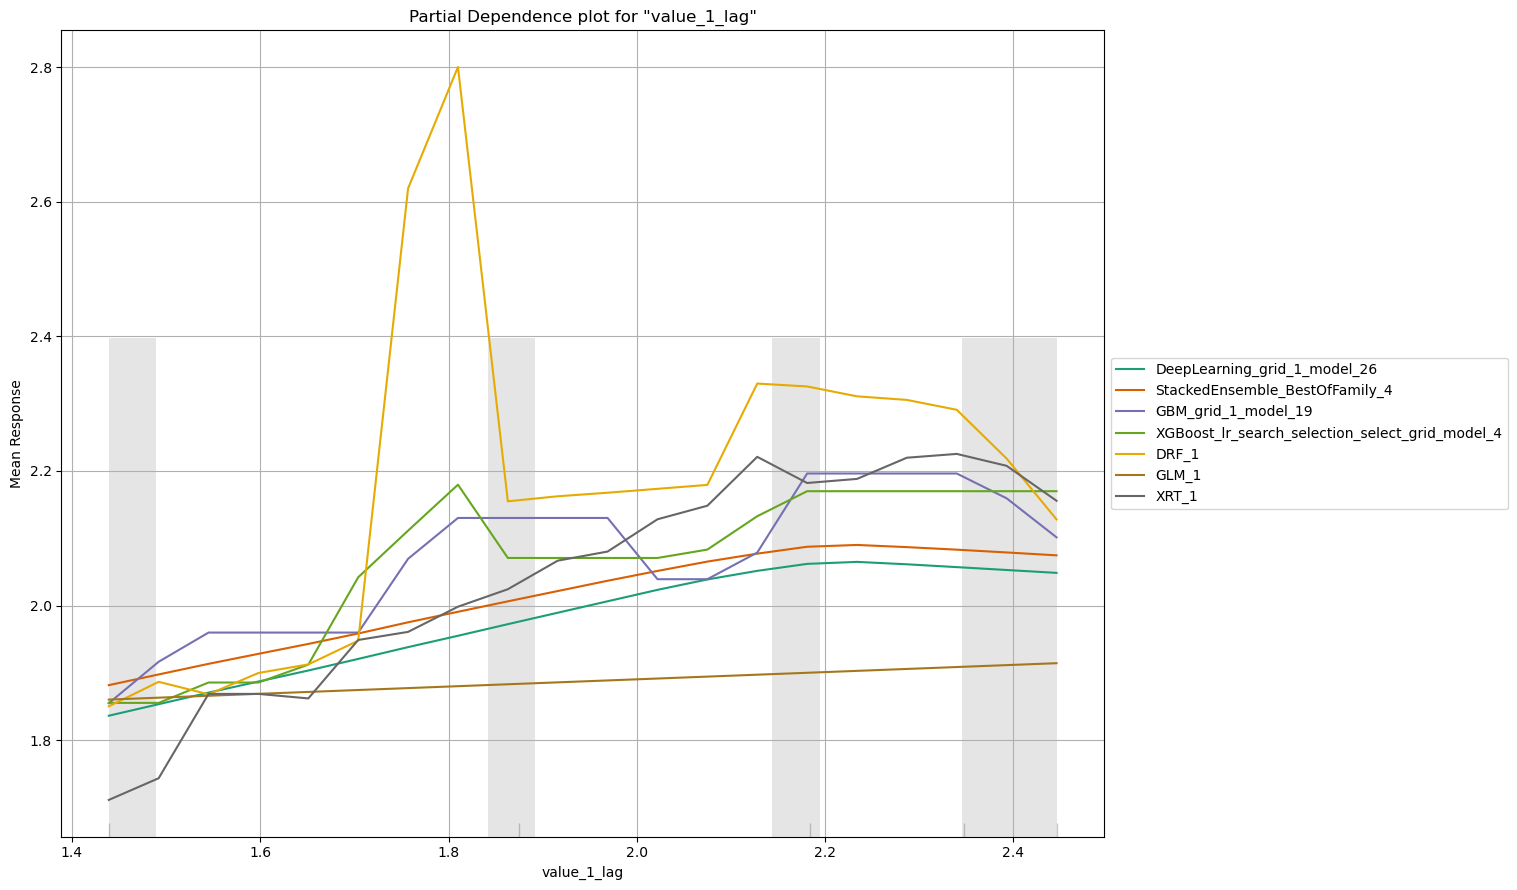

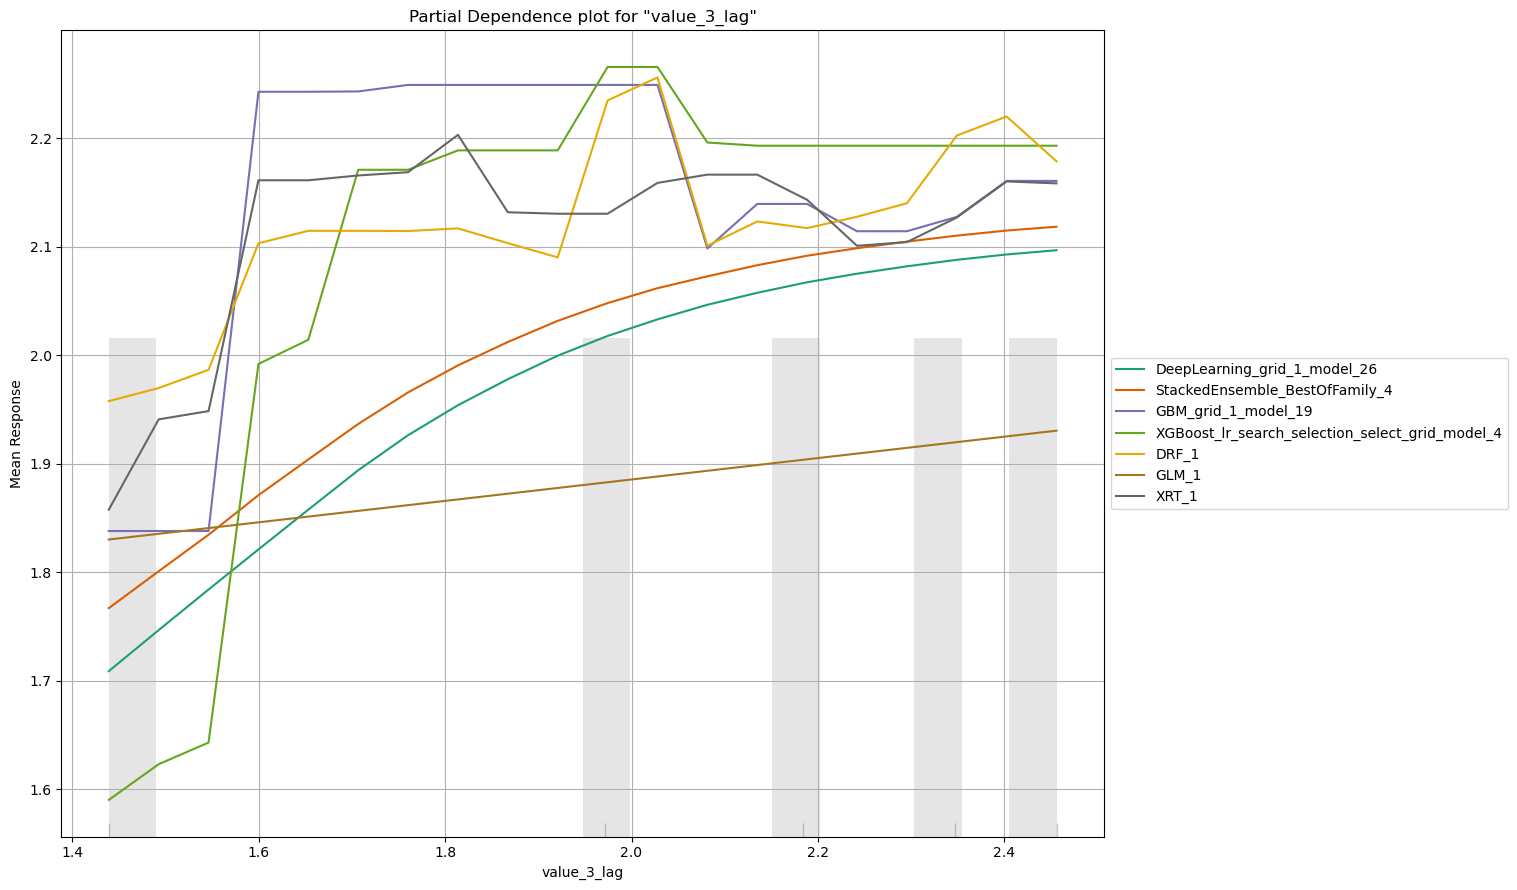

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

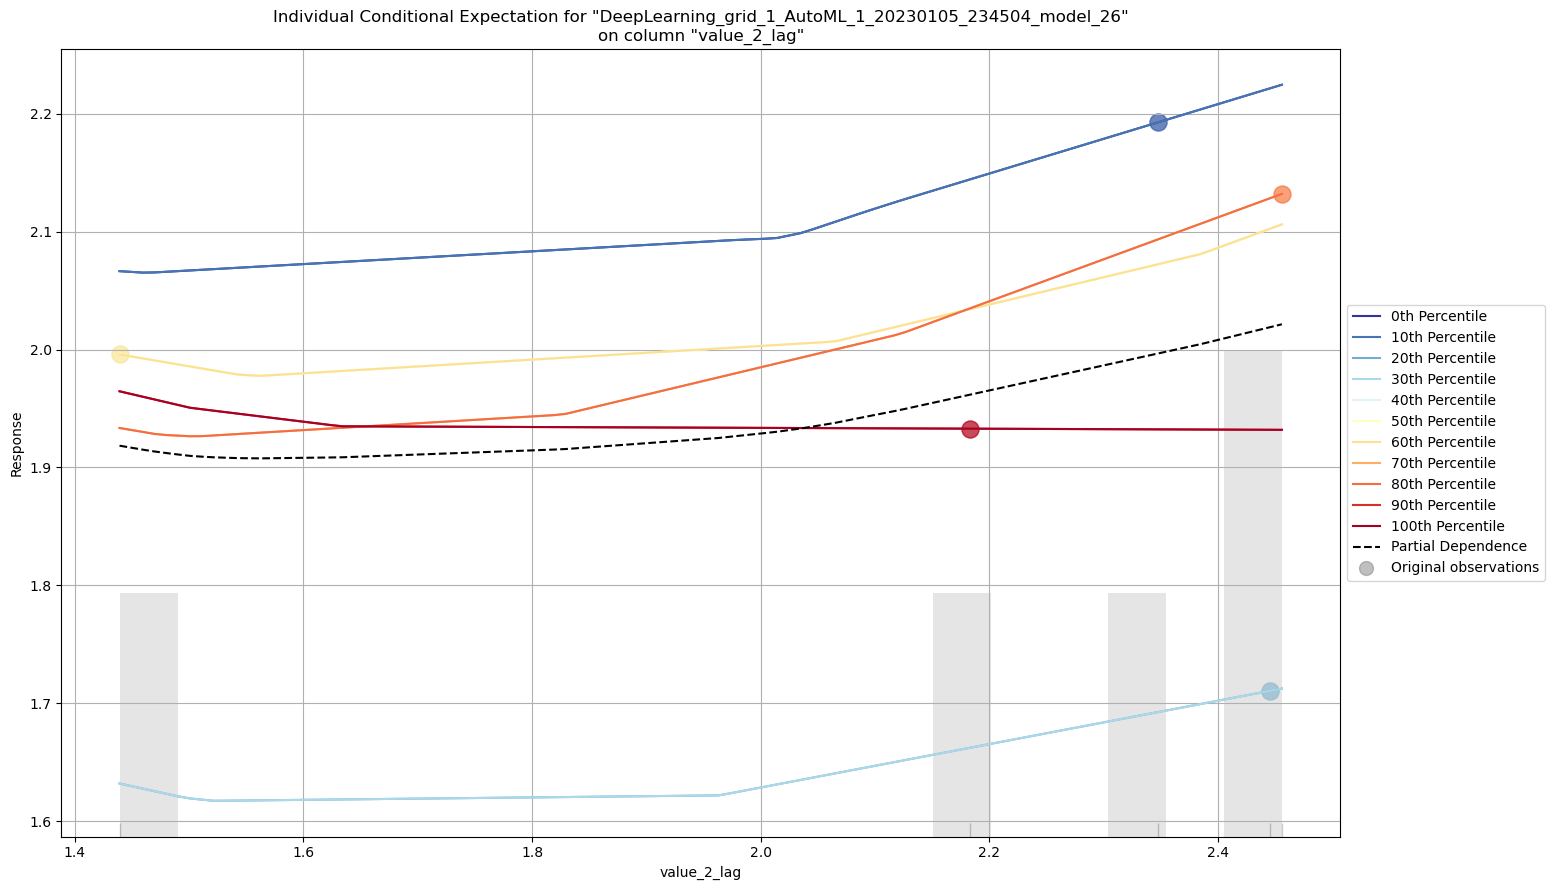

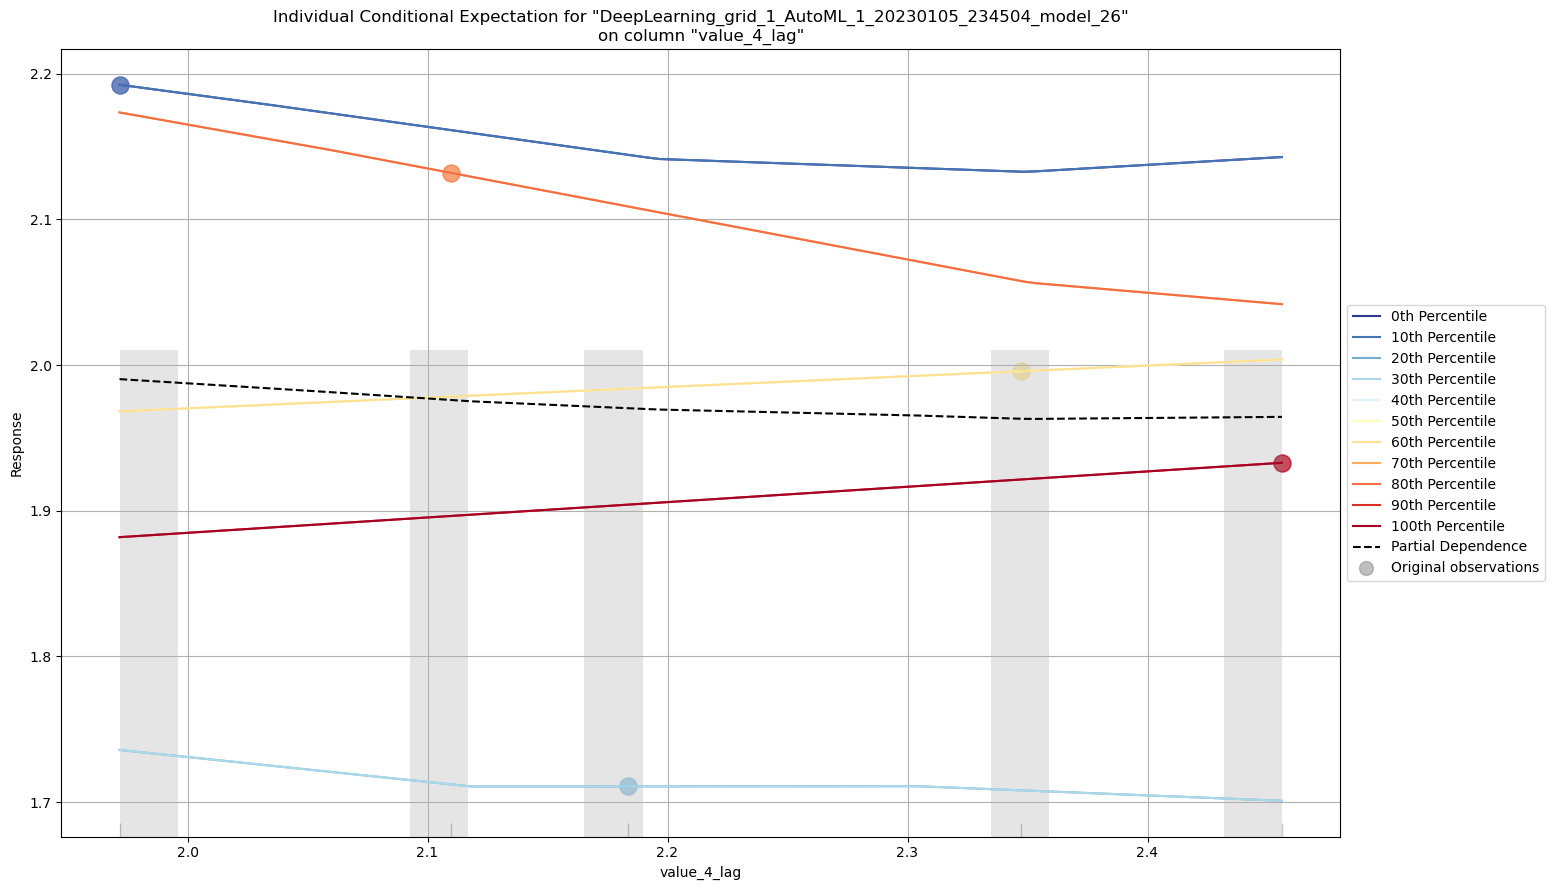

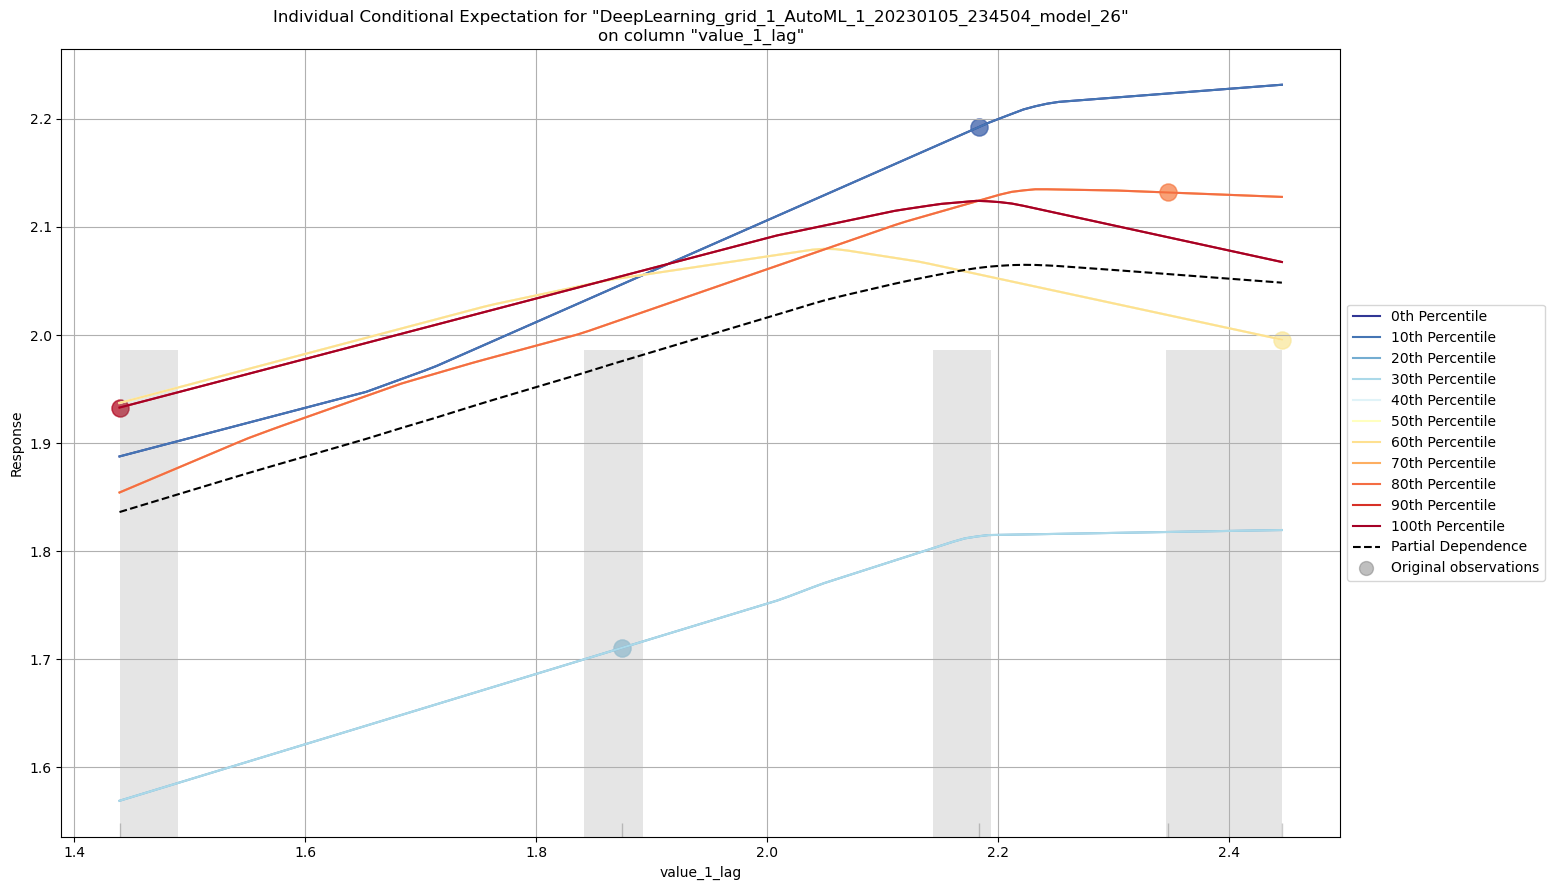

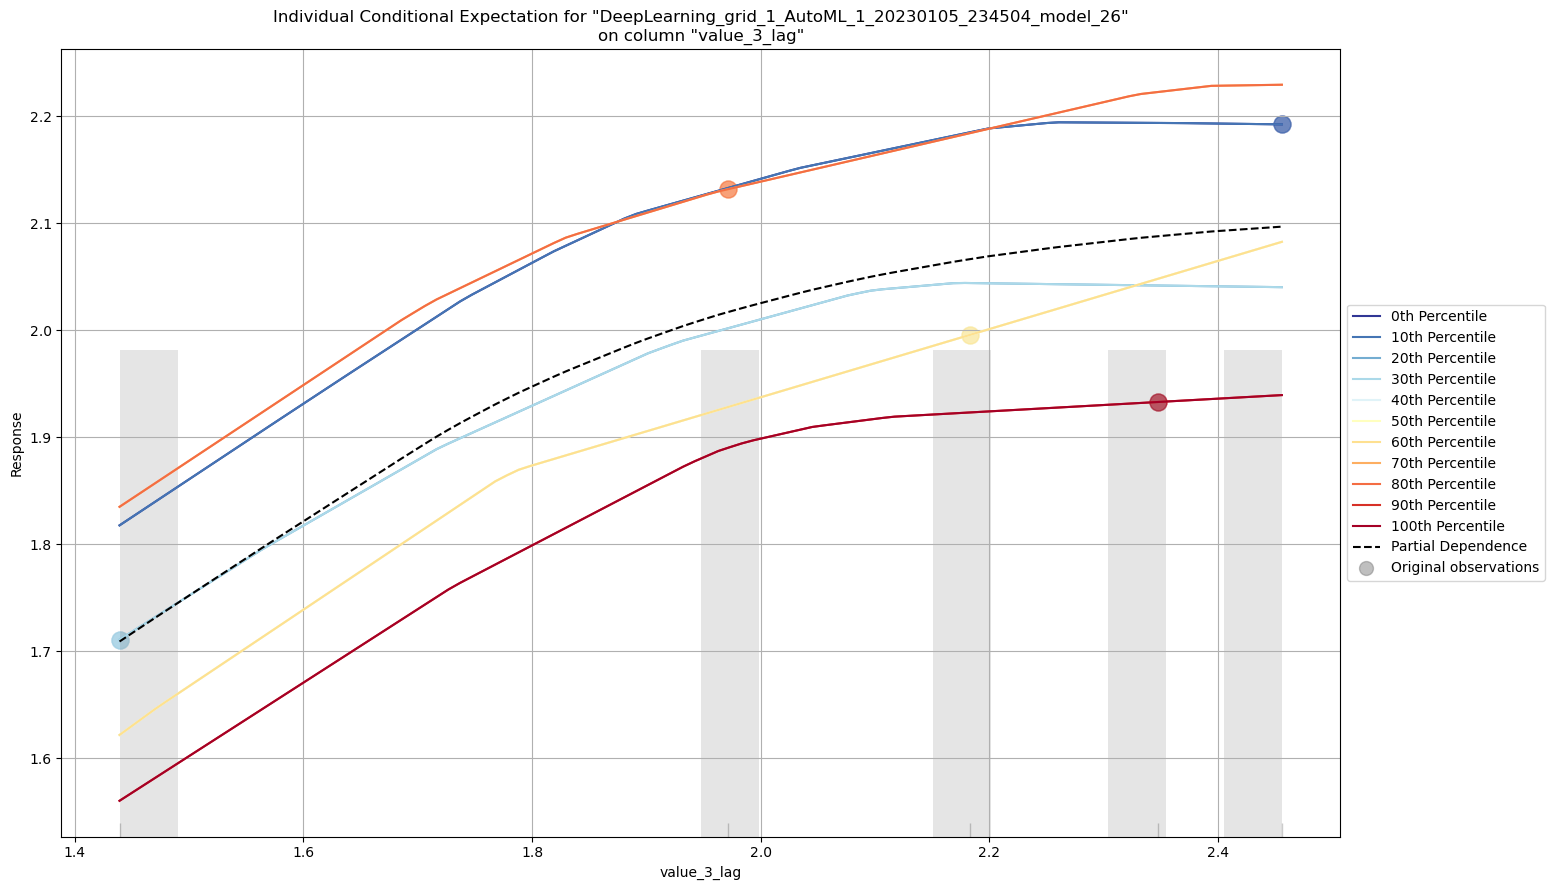

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_BestOfFamily_5_AutoML_1_20230105_234504,0.339578,0.115313,0.226337,0.120819,0.115313,311,0.201381,StackedEnsemble
GBM_grid_1_AutoML_1_20230105_234504_model_117,0.339718,0.115408,0.294804,0.115599,0.115408,25,0.018162,GBM
DeepLearning_grid_3_AutoML_1_20230105_234504_model_5,0.344319,0.118555,0.292367,0.117674,0.118555,27,0.0374,DeepLearning
DeepLearning_grid_1_AutoML_1_20230105_234504_model_35,0.344384,0.118601,0.313295,0.11791,0.118601,6,0.011982,DeepLearning
XGBoost_grid_1_AutoML_1_20230105_234504_model_5,0.360908,0.130255,0.283428,0.121953,0.130255,36,0.015016,XGBoost
DeepLearning_grid_1_AutoML_1_20230105_234504_model_34,0.365454,0.133557,0.306967,0.126314,0.133557,9,0.012054,DeepLearning
GLM_1_AutoML_1_20230105_234504,0.366102,0.134031,0.309414,0.12557,0.134031,15,0.057329,GLM
DeepLearning_grid_2_AutoML_1_20230105_234504_model_19,0.367845,0.13531,0.305655,0.12782,0.13531,41,0.03216,DeepLearning
DeepLearning_grid_1_AutoML_1_20230105_234504_model_20,0.371606,0.138091,0.286908,0.127666,0.138091,800,0.014534,DeepLearning
DeepLearning_grid_1_AutoML_1_20230105_234504_model_15,0.376182,0.141513,0.299391,0.129933,0.141513,1069,0.014452,DeepLearning


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [35]:
h2o_automl.explain(h2o_fram_test)